# Overview

- カリフォルニア州の禁煙キャンペーンデータに対する因果効果の検証。
- 手順：
    - まずは RCT のように介入群と対照群にわけて、平行トレンド仮定してプロットする。
    - 次に介入前の時系列のプロットして、平行トレンド仮定が満たされないことを確認する。
    - さらに対照群を平行トレンド仮定を満たす州に限定して、回帰モデルによる介入効果を確認する。これを合成コントロールという。
    - 最後に CausalImpact を用いて介入効果を確認する。
- データセットは以下：
    - [Ecdat/data/Cigar.rda | GitHub](https://github.com/cran/Ecdat/blob/master/data/Cigar.rda)

### TODO
- predict はどういう単位で inference しているか。
- fitting した時系列モデル自体のよさはどう評価するのか。文献調査？
- 時系列データの特徴量（ここでは米国の州の数）が多い場合や、複数の特徴量を使いたい場合にどうするか。
- そもそもなんでローカルレベルモデルで時系列予測しているのか。

# 準備

In [1]:
### rdata パッケージをインストール
!pip install -q rdata
!pip install -q pycausalimpact==0.1.1
!pip uninstall pandas -y
!pip install -q pandas==1.1.3

### データセットをダウンロード
!wget -q https://github.com/cran/Ecdat/raw/master/data/Cigar.rda

Found existing installation: pandas 1.1.3
Uninstalling pandas-1.1.3:
  Successfully uninstalled pandas-1.1.3


In [2]:
### インポート
from causalimpact import CausalImpact
import statsmodels.api as sm
import rdata

In [3]:
### statsmodels からデータセットを取得する場合
sm.datasets.get_rdataset('Cigar', 'Ecdat').data

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
0,1,63,28.6,3383.0,2236.5,30.6,1558.304530,93.9,26.1
1,1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5
2,1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9
3,1,66,31.5,3524.0,2369.7,32.4,1915.160357,96.4,29.5
4,1,67,31.6,3533.0,2393.7,33.4,2023.546368,95.5,29.6
...,...,...,...,...,...,...,...,...,...
1375,51,88,112.9,479.0,353.0,118.3,11803.000000,114.3,115.3
1376,51,89,118.6,475.0,352.0,124.0,12399.000000,111.4,123.0
1377,51,90,129.5,470.9,348.9,130.7,13871.000000,96.9,138.9
1378,51,91,127.0,477.1,355.2,136.2,14675.000000,109.1,143.6


In [4]:
### wget によって取得したデータセットを読み込む場合
parsed = rdata.parser.parse_file('Cigar.rda')
converted = rdata.conversion.convert(parsed)
df = converted['Cigar']
df

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
1,1,63,28.6,3383.0,2236.5,30.6,1558.304530,93.9,26.1
2,1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5
3,1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9
4,1,66,31.5,3524.0,2369.7,32.4,1915.160357,96.4,29.5
5,1,67,31.6,3533.0,2393.7,33.4,2023.546368,95.5,29.6
...,...,...,...,...,...,...,...,...,...
1376,51,88,112.9,479.0,353.0,118.3,11803.000000,114.3,115.3
1377,51,89,118.6,475.0,352.0,124.0,12399.000000,111.4,123.0
1378,51,90,129.5,470.9,348.9,130.7,13871.000000,96.9,138.9
1379,51,91,127.0,477.1,355.2,136.2,14675.000000,109.1,143.6


In [5]:
### データ加工
use_df = df.copy()

### 1970年以降のデータを抽出
use_df = use_df.query('year >= 70')
display(use_df.head(3))

### 独自介入を行った州を除外
except_list = [3, 9, 10, 21, 22, 23, 31, 33, 48]
use_df = use_df[~use_df['state'].isin(except_list)]

print(use_df['state'].unique())

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
8,1,70,39.6,3444.0,2394.6,38.8,2591.039159,89.8,34.3
9,1,71,42.7,3481.0,2443.5,40.5,2785.315971,95.4,35.8
10,1,72,42.3,3511.0,2484.7,41.8,3034.808297,101.1,37.4


[ 1  4  5  7  8 11 13 14 15 16 17 18 19 20 24 25 26 27 28 29 30 32 35 36
 37 39 40 41 42 43 44 45 46 47 49 50 51]


In [6]:
### 州を介入群と制御群にふりわけ
cigar_did = use_df.copy()

### 介入タイミングを追加
cigar_did['period'] = cigar_did['year'].apply(lambda x: 'after' if x > 87 else 'before')

### CA or Rest of US
cigar_did['state'] = cigar_did['state'].apply(lambda x: 'CA' if x == 5 else 'Rest of US')

### 16歳以上のタバコ売上
### sale: 1人あたり売上, pop16: 16歳以上の人口
cigar_did['sales_pop16'] = cigar_did['sales'] * cigar_did['pop16']

cigar_did

,state,year,price,pop,pop16,cpi,ndi,sales,pimin,period,sales_pop16
8,Rest of US,70,39.6,3444.0,2394.6,38.8,2591.039159,89.8,34.3,before,215035.08
9,Rest of US,71,42.7,3481.0,2443.5,40.5,2785.315971,95.4,35.8,before,233109.90
10,Rest of US,72,42.3,3511.0,2484.7,41.8,3034.808297,101.1,37.4,before,251203.17
11,Rest of US,73,42.1,3540.0,2526.0,44.4,3387.574086,102.9,37.3,before,259925.40
12,Rest of US,74,43.1,3574.0,2573.9,49.3,3718.867175,108.2,41.4,before,278495.98
...,...,...,...,...,...,...,...,...,...,...,...
1376,Rest of US,88,112.9,479.0,353.0,118.3,11803.000000,114.3,115.3,after,40347.90
1377,Rest of US,89,118.6,475.0,352.0,124.0,12399.000000,111.4,123.0,after,39212.80
1378,Rest of US,90,129.5,470.9,348.9,130.7,13871.000000,96.9,138.9,after,33808.41
1379,Rest of US,91,127.0,477.1,355.2,136.2,14675.000000,109.1,143.6,after,38752.32


In [7]:
### 整形
summarized = cigar_did.groupby(['period', 'state'], as_index=False)[['pop16', 'sales_pop16']].mean()
summarized = summarized.sort_values('period', ascending=False)

### 16歳以上1人あたりの sales
summarized['sales'] = summarized['sales_pop16'] / summarized['pop16']
summarized

,period,state,pop16,sales_pop16,sales
2,before,CA,17674.250000,2.061836e+06,116.657645
3,before,Rest of US,2605.420216,3.304769e+05,126.842072
0,after,CA,22355.320000,1.724154e+06,77.124997
1,after,Rest of US,2948.603889,3.151694e+05,106.887669


# 平行トレンドを仮定したプロット

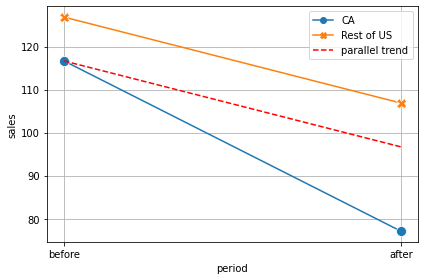

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

### プロット
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(6, 4))
sns.lineplot(data=summarized, 
             x='period', 
             y='sales', 
             hue='state', 
             style='state', 
             markersize=10,
             dashes=False, 
             markers=True, 
             ax=ax)

### 半実仮想線
x = ['before', 'after']
y = [116.657645, 106.887669 - (126.842072 - 116.657645)]
ax.plot(x, y, '--', color='r', label='parallel trend')
ax.legend()
ax.grid()
plt.show()

- 赤い点線が並行トレンド。青い点線が介入群。
- 禁煙キャンペーンがなくても減少傾向にある。
- CA の介入効果は20程度。

# 平行トレンドの確認

In [9]:
use_df

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
8,1,70,39.6,3444.0,2394.6,38.8,2591.039159,89.8,34.3
9,1,71,42.7,3481.0,2443.5,40.5,2785.315971,95.4,35.8
10,1,72,42.3,3511.0,2484.7,41.8,3034.808297,101.1,37.4
11,1,73,42.1,3540.0,2526.0,44.4,3387.574086,102.9,37.3
12,1,74,43.1,3574.0,2573.9,49.3,3718.867175,108.2,41.4
...,...,...,...,...,...,...,...,...,...
1376,51,88,112.9,479.0,353.0,118.3,11803.000000,114.3,115.3
1377,51,89,118.6,475.0,352.0,124.0,12399.000000,111.4,123.0
1378,51,90,129.5,470.9,348.9,130.7,13871.000000,96.9,138.9
1379,51,91,127.0,477.1,355.2,136.2,14675.000000,109.1,143.6


In [10]:
use_df['post'] = use_df['year'].apply(lambda x: 1 if x > 87 else 0)
use_df['ca'] = use_df['state'].apply(lambda x: 1 if x==5 else 0)
use_df['sales_pop16'] = use_df['sales'] * use_df['pop16']
cigar_did_sum = use_df.groupby(['post', 'year', 'ca'], as_index=False)['pop16', 'sales_pop16'].mean()
cigar_did_sum['sales'] = cigar_did_sum['sales_pop16'] / cigar_did_sum['pop16']
cigar_did_sum['treatment'] = cigar_did_sum['ca'] * cigar_did_sum['post']
cigar_did_sum.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,post,year,ca,pop16,sales_pop16,sales,treatment
0,0,70,0,2268.744444,2.609811e+05,115.033284,0
1,0,70,1,14317.600000,1.761065e+06,123.000000,0
2,0,71,0,2319.763889,2.740049e+05,118.117568,0
3,0,71,1,14670.500000,1.775130e+06,121.000000,0
4,0,72,0,2360.625000,2.852985e+05,120.857179,0


In [11]:
import pandas as pd

y = cigar_did_sum['sales']
x = pd.get_dummies(cigar_did_sum[['ca', 'post', 'treatment', 'year']], columns=['year'], drop_first=True)

### 定数項を追加（値がすべて1の列 'const' が追加される）
x = sm.add_constant(x)

### 回帰分析
results = sm.OLS(y, x).fit()
### results.summary()

In [12]:
coef = results.summary().tables[1]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,123.5615,4.519,27.340,0.000,114.163,132.960
ca,-9.0898,2.074,-4.384,0.000,-13.402,-4.777
post,-13.8569,4.423,-3.133,0.005,-23.054,-4.660
treatment,-20.5435,4.447,-4.619,0.000,-29.792,-11.295
year_71,0.5421,6.221,0.087,0.931,-12.395,13.479
year_72,3.1619,6.221,0.508,0.617,-9.775,16.099
year_73,4.5931,6.221,0.738,0.468,-8.344,17.530
year_74,7.8036,6.221,1.254,0.223,-5.133,20.741
year_75,8.8485,6.221,1.422,0.170,-4.089,21.786
year_76,11.3818,6.221,1.830,0.082,-1.555,24.319


In [13]:
### 並行トレンド仮定の確認
sales_trend = cigar_did.groupby(['year', 'state'], as_index=False)['pop16', 'sales_pop16'].mean()
sales_trend['sales'] = sales_trend['sales_pop16'] / sales_trend['pop16']
sales_trend.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,year,state,pop16,sales_pop16,sales
0,70,CA,14317.600000,1.761065e+06,123.000000
1,70,Rest of US,2268.744444,2.609811e+05,115.033284
2,71,CA,14670.500000,1.775130e+06,121.000000


16歳以上のひとりあたりタバコ売上推移


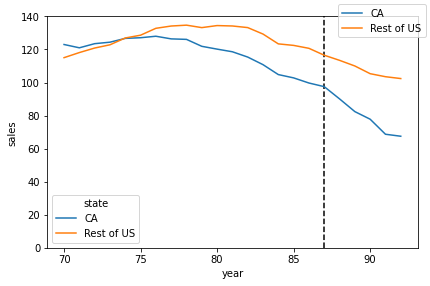

In [14]:
### プロット
print('16歳以上のひとりあたりタバコ売上推移')
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(6, 4))
sns.lineplot(data=sales_trend, 
             x='year', 
             y='sales', 
             hue='state', 
             style='state', 
             markersize=10,
             dashes=False, 
             # markers=True, 
             ax=ax)
ax.vlines(x=87, ymin=0, ymax=140, color='k', linestyles='--')
ax.set_ylim(0, 140)
fig.legend()
fig.show()

並行トレンド仮定は崩れている。

# 合成コントロール

In [15]:
### 並行トレンド仮定を満たす州を制御群にする
include_list = [5, 8, 14, 27]
cigar_did_area = use_df.copy()
cigar_did_area = cigar_did_area[cigar_did_area['state'].isin(include_list)]
cigar_did_area['period'] = cigar_did_area['year'].apply(lambda x: 'after' if x > 87 else 'before')

cigar_did_area

,state,year,price,pop,pop16,cpi,ndi,sales,pimin,post,ca,sales_pop16,period
98,5,70,38.8,19953.0,14317.6,38.8,4192.781105,123.0,37.1,0,1,1761064.80,before
99,5,71,39.7,20266.0,14670.5,40.5,4414.306911,121.0,38.5,0,1,1775130.50,before
100,5,72,39.9,20447.0,14938.3,41.8,4650.961308,123.5,38.0,0,1,1844880.05,before
101,5,73,39.9,20670.0,15243.7,44.4,5103.738443,124.4,38.7,0,1,1896316.28,before
102,5,74,41.9,20915.0,15566.6,49.3,5607.304421,126.7,39.2,0,1,1972288.22,before
...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,27,88,115.3,805.0,608.0,118.3,11371.000000,87.1,112.9,1,0,52956.80,after
717,27,89,123.0,806.0,610.0,124.0,12390.000000,86.2,118.6,1,0,52582.00,after
718,27,90,140.4,805.0,609.2,130.7,13318.000000,84.7,129.5,1,0,51599.24,after
719,27,91,143.6,814.1,618.4,136.2,14079.000000,82.9,127.0,1,0,51265.36,after


In [16]:
sales_trend_area = cigar_did_area.groupby(['year', 'state'], as_index=False)['pop16', 'sales_pop16'].mean()
sales_trend_area['sales'] = sales_trend_area['sales_pop16'] / sales_trend_area['pop16']
sales_trend_area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,year,state,pop16,sales_pop16,sales
0,70,5,14317.6,1761064.80,123.0
1,70,8,378.2,58621.00,155.0
2,70,14,7860.3,980965.44,124.8
3,70,27,482.8,53687.36,111.2
4,71,5,14670.5,1775130.50,121.0
...,...,...,...,...,...
87,91,27,618.4,51265.36,82.9
88,92,5,22920.0,1547100.00,67.5
89,92,8,543.6,65232.00,120.0
90,92,14,9138.5,866329.80,94.8


16歳以上のひとりあたりタバコ売上推移


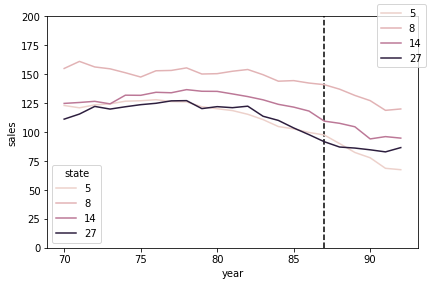

In [17]:
### プロット
print('16歳以上のひとりあたりタバコ売上推移')
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=(6, 4))
sns.lineplot(data=sales_trend_area, 
             x='year', 
             y='sales', 
             hue='state', 
             style='state', 
             markersize=10,
             dashes=False, 
             # markers=True, 
             ax=ax)
ax.vlines(x=87, ymin=0, ymax=200, color='k', linestyles='--')
ax.set_ylim(0, 200)
fig.legend()
fig.show()

# CausalImpcat

In [18]:
df.head(3)

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
1,1,63,28.6,3383.0,2236.5,30.6,1558.304530,93.9,26.1
2,1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5
3,1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9


In [19]:
### 19070年以降のデータのみ使用
use_df = df.query('year >= 70')

### 独自の介入を行った州を除く
except_list = [3, 9, 10, 21, 22, 23, 31, 33, 48]
use_df = use_df[~use_df['state'].isin(except_list)]

### ピボットしてデータを整形
### index にyear, column に州番号（最左に CA 州である5番）
pv_df = use_df.pivot(index='year', columns='state', values='sales')
cols = [5] + sorted([i for i in pv_df.columns if i != 5])
pv_df = pv_df[cols]
pv_df.columns = [str(i) for i in pv_df.columns]

pv_df.head(3)

,5,1,4,7,8,11,13,14,15,16,...,41,42,43,44,45,46,47,49,50,51
year,,,,,,,,,,,,,,,,,,,,,
70,123.0,89.8,100.3,120.0,155.0,109.9,102.4,124.8,134.6,108.5,...,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
71,121.0,95.4,104.1,117.6,161.1,115.7,108.5,125.6,139.3,108.4,...,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
72,123.5,101.1,103.9,110.8,156.3,117.0,126.1,126.6,149.2,109.4,...,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, model_args, standardize. After release 0.14, this will raise.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

############### summary ###############
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    77.3               386.5
Prediction (s.d.)         81.4 (0.12)        407.02 (0.62)
95% CI                    [81.16, 81.64]     [405.79, 408.22]

Absolute effect (s.d.)    -4.1 (0.12)        -20.52 (0.62)
95% CI                    [-4.34, -3.86]     [-21.72, -19.29]

Relative effect (s.d.)    -5.04% (0.15%)     -5.04% (0.15%)
95% CI                    [-5.34%, -4.74%]   [-5.34%, -4.74%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
############### report ###############
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 77.3. By contrast, in the absence of an
intervention, we would have expected an average response of 81.4.
The 95% interval of this counter

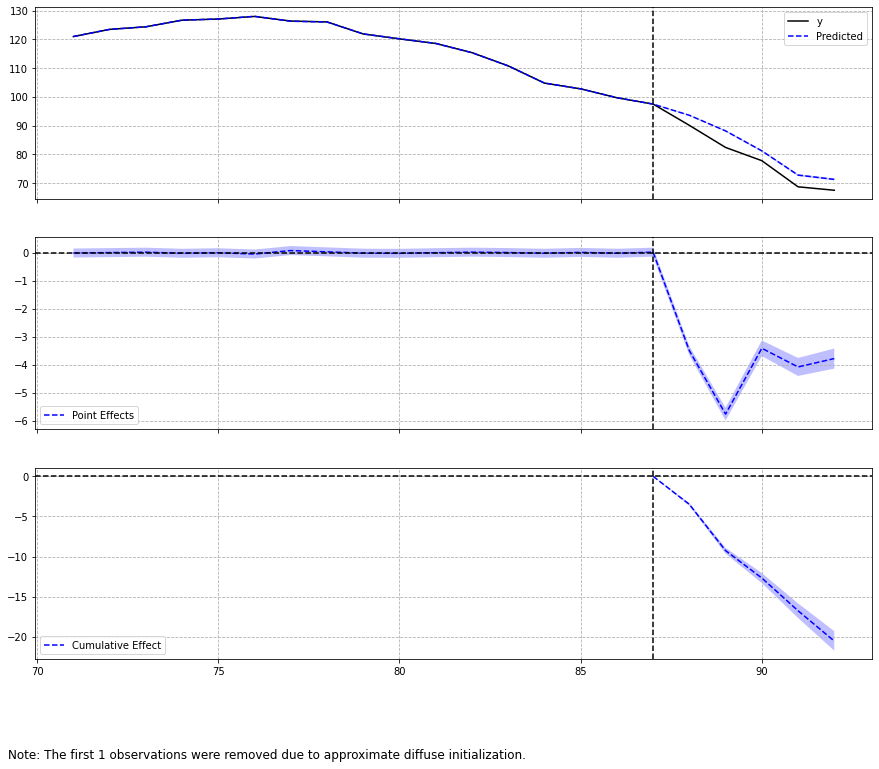

In [20]:
### causalimpact による
pre = [70, 87]
post = [88, 92]

ci = CausalImpact(pv_df, pre, post, model_args={'fit_method': 'hmc'})

print('############### summary ###############')
print(ci.summary())

print('############### report ###############')
print(ci.summary(output='report'))

print('############### plot ###############')
ci.plot()

結果
- １つ目のグラフは、カリフォルニアにおけるタバコの売上の予測値と実測値。介入が始まったタイミングは縦の点線。
- ２つ目のグラフは、予測値と実測値の乖離。１つ目のグラフで、予測値よりも実測値が低く出いているため、ここではマイナスの値になっている。
- ３つ目のグラフは、２つ目のグラフの介入のタイミング以降の累積値。

考察
- 実装をみると、時系列モデルには statsmodels の `from statsmodels.tsa.statespace.structural import UnobservedComponents` を使っている。
https://github.com/jamalsenouci/causalimpact/blob/master/causalimpact/model.py
- これは状態空間モデルのローカルレベルモデル。